# Processing data for wave height forecast
In this notebook, we process the data that we use to train and fine tune our models. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
pio.renderers.default = 'notebook' 
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Read and plot raw data

In [2]:
# Read raw data
# ==============================================================================
data_dir = 'Data/spain/four years'
file = '/17286_27577_3106036_WAVE_20200618145316_20240618145316.csv'

col_names = ['Fecha (GMT)',	'Altura Signif. del Oleaje(m)',	'Periodo Medio(s)', 'Periodo de Pico(s)', 'Direcc. Media de Proced.(0=N 90=E)',	'Mar de viento:  Altura signif. Espectral(m)',	'Mar de viento: Direcc. Media de Proced.(0=N 90=E)', 'Mar de fondo 1:  Altura signif. Espectral(m)', 'Mar de fondo 1:  Periodo Medio Espectral(s)',	'Mar de fondo 1: Direcc. Media de Proced.(0=N 90=E)', 'Mar de fondo 2:  Altura signif. Espectral(m)', 'Mar de fondo 2:  Periodo Medio Espectral(s)', 'Mar de fondo 2: Direcc. Media de Proced.(0=N 90=E)']
df_original = pd.read_csv(data_dir + file, 
                 skiprows = 2, 
                 sep = '\t',
                 header = None,
                 names = col_names)

df_original['datetime'] = pd.to_datetime(df_original['Fecha (GMT)'].str.replace(r'\s+', ' ', regex=True), format='%Y %m %d %H')

df_original.head()

,Fecha (GMT),Altura Signif. del Oleaje(m),Periodo Medio(s),Periodo de Pico(s),Direcc. Media de Proced.(0=N 90=E),Mar de viento: Altura signif. Espectral(m),Mar de viento: Direcc. Media de Proced.(0=N 90=E),Mar de fondo 1: Altura signif. Espectral(m),Mar de fondo 1: Periodo Medio Espectral(s),Mar de fondo 1: Direcc. Media de Proced.(0=N 90=E),Mar de fondo 2: Altura signif. Espectral(m),Mar de fondo 2: Periodo Medio Espectral(s),Mar de fondo 2: Direcc. Media de Proced.(0=N 90=E),datetime
0,2020 06 18 00,0.78,4.92,6.21,333,0.0,180,0.75,4.75,331,0.21,13.74,356.0,2020-06-18 00:00:00
1,2020 06 18 01,0.76,5.06,6.21,334,0.0,180,0.72,4.82,331,0.24,13.58,356.0,2020-06-18 01:00:00
2,2020 06 18 02,0.74,5.16,6.21,334,0.0,180,0.69,4.84,331,0.27,13.45,355.0,2020-06-18 02:00:00
3,2020 06 18 03,0.73,5.22,6.21,335,0.0,180,0.67,4.83,331,0.30,13.31,355.0,2020-06-18 03:00:00
4,2020 06 18 04,0.73,5.28,13.32,336,0.0,180,0.64,4.73,331,0.64,25.96,355.0,2020-06-18 04:00:00


In [3]:
# Slice off variable of interest
# ==============================================================================
df = df_original[['datetime', 'Altura Signif. del Oleaje(m)']].copy()
df.rename(columns = {'Altura Signif. del Oleaje(m)':'wave_height'}, inplace = True)
df.sort_values(by=['datetime'], inplace=True)
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')

print(df.shape)
df.head(10)

(35088, 1)


,wave_height
datetime,
2020-06-18 00:00:00,0.78
2020-06-18 01:00:00,0.76
2020-06-18 02:00:00,0.74
2020-06-18 03:00:00,0.73
2020-06-18 04:00:00,0.73
2020-06-18 05:00:00,0.73
2020-06-18 06:00:00,0.73
2020-06-18 07:00:00,0.74
2020-06-18 08:00:00,0.74


[]

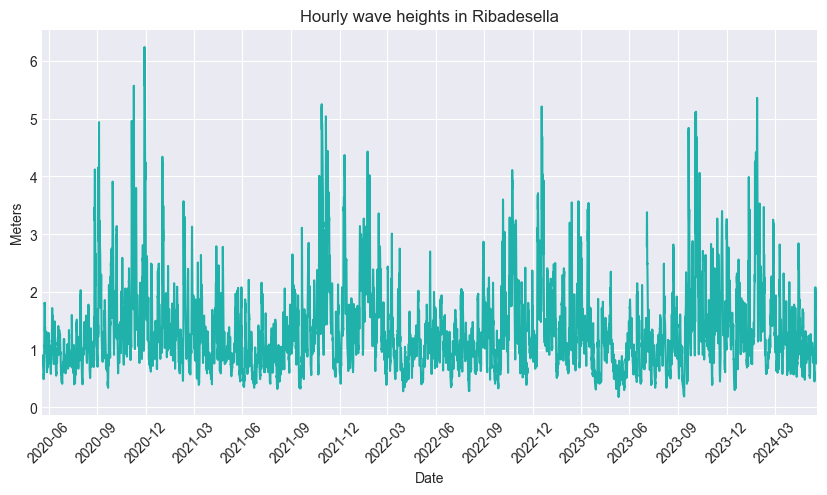

In [4]:
# Plot raw data
# ==============================================================================
fig, ax = plt.subplots(1,1, figsize = (10,5))

df['wave_height'].plot(ax=ax, color = 'lightseagreen')

ax.set_title('Hourly wave heights in Ribadesella')
ax.set_ylabel('Meters')
ax.set_xlabel('Date')

# Add more ticks to the x-axis
ax.set_xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='3M'))
ax.set_xticklabels(pd.date_range(start=df.index.min(), end=df.index.max(), freq='3M').strftime('%Y-%m'), rotation=45)

# Add grid
ax.grid(True)

plt.plot()

## Dealing with null values. 
The raw data seems to have a few missing values. Since there aren't a lot relative to the sample size, I am going to impute them with the weekly average. I don't think this will have a huge impact on the predictive ability of the model. More importantly, the null values do not seem to leak across sets.


In [5]:
df.isnull().value_counts()

wave_height
False          34848
True             240
Name: count, dtype: int64

In [10]:
df[df['wave_height'].isnull()]

,wave_height
datetime,
2020-08-25 13:00:00,NaN
2020-08-25 14:00:00,NaN
2020-08-25 15:00:00,NaN
2020-08-25 16:00:00,NaN
2020-08-25 17:00:00,NaN
...,...
2023-11-16 20:00:00,NaN
2023-11-16 21:00:00,NaN
2023-11-16 22:00:00,NaN


In [8]:
df[df['wave_height'].isnull() & 
                 (df.index.month.isin([7, 8, 9])) & 
                 (df.index.year == 2023)]

,wave_height
datetime,
2023-08-02 01:00:00,NaN
2023-08-02 02:00:00,NaN
2023-08-02 03:00:00,NaN
2023-08-02 04:00:00,NaN
2023-08-02 05:00:00,NaN
2023-08-02 06:00:00,NaN
2023-08-02 07:00:00,NaN
2023-08-02 08:00:00,NaN
2023-08-02 09:00:00,NaN


In [12]:
# Impute missing values
# ==============================================================================
def fill_null_with_weekly_average(df, column_names):
    # Ensure the index is a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    for column_name in column_names:

        # Calculate the weekly average
        weekly_avg = df[column_name].resample('W').mean()

        # Forward-fill the weekly average to match the original index
        weekly_avg_filled = weekly_avg.reindex(df.index, method='ffill')

        # Fill null values in the original series with the corresponding weekly average
        df[column_name].fillna(weekly_avg_filled, inplace=True)

    return df

df = fill_null_with_weekly_average(df, ['wave_height'])

df.isnull().value_counts()

wave_height
False          35088
Name: count, dtype: int64

## Aggregate data at weekely level
We could forecast at the hourly level. However, the recursive forecasts will quickly get very volatile, i.e. the prediction intervals will get huge and comparing the models will be impossible. 

In [13]:
# Aggregate data to daily frequency - highest observed wave
# ==============================================================================
df = (
    df
    .resample(rule="D", closed="left", label="right")
    .agg({"wave_height": "max"})
)

In [26]:
# Basic stats
# ==============================================================================
print('Mean:', df['wave_height'].mean())
print('Standard Deviation:', df['wave_height'].std())

Mean: 1.6267253328731612
Standard Deviation: 0.864988161576185


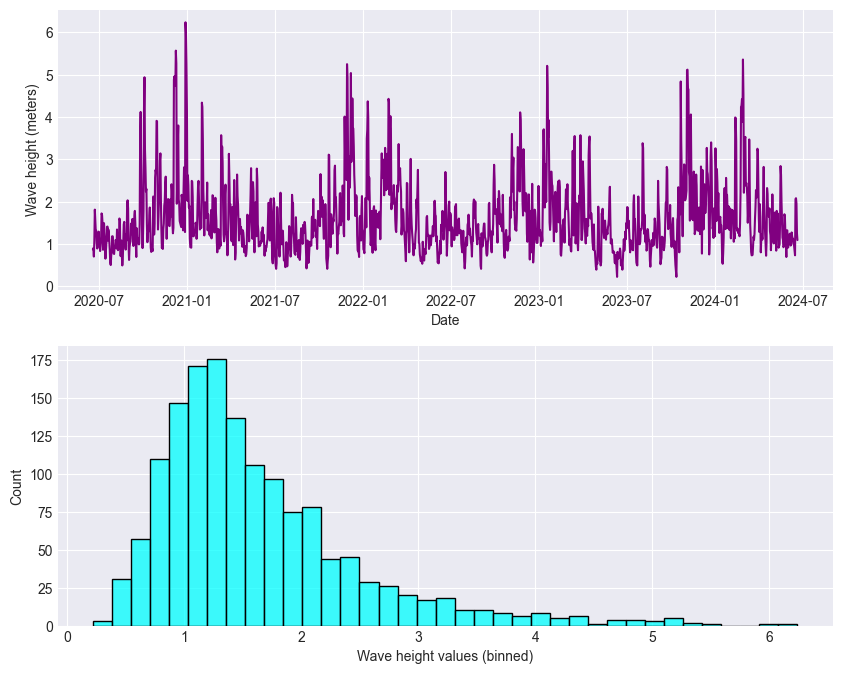

In [27]:
# Plot target variable distribution 
# ==============================================================================
fig, ax = plt.subplots(2,1, figsize = (10,8))

ax[0].plot(df['wave_height'], color = 'purple')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Wave height (meters)')

sns.histplot(x = df['wave_height'], ax = ax[1], color = 'cyan')
ax[1].set_xlabel('Wave height values (binned)')

plt.show()

## Visualise train/val/test split

In [15]:
# Train-test split
# ==============================================================================
one_month = (-1)*30 # One month
two_months = (-1)*60 # Two months

end_val = two_months + two_months + one_month
end_train = end_val + two_months + two_months + one_month 

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-19 00:00:00 --- 2023-08-24 00:00:00  (n=1162)
Validation dates : 2023-08-25 00:00:00 --- 2024-01-21 00:00:00  (n=150)
Test dates       : 2024-01-22 00:00:00 --- 2024-06-19 00:00:00  (n=150)


In [25]:
# Interactive plot of clean and split time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['wave_height'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=df_val.index, y=df_val['wave_height'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['wave_height'], mode='lines', name='Test'))
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Wave height (meters)",
    legend_title="Partition:",
    width=900,
    height=500,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

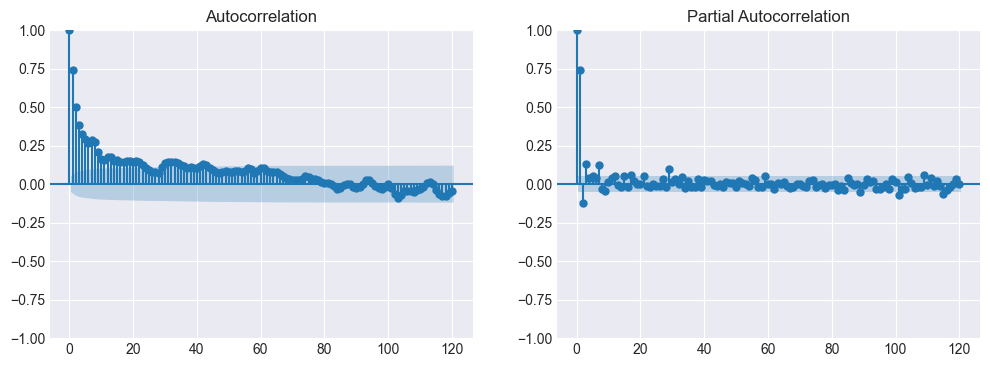

In [18]:
# ACF and PACF
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df['wave_height'], ax=ax[0], lags=120)
plot_pacf(df['wave_height'], ax=ax[1], lags=120)

plt.show()

In [19]:
# Save data
# ==============================================================================
df.to_csv(data_dir + '/spain_clean_daily.csv')